In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
from gridworld.environment import WindyGridworld
from tensorflow import keras
from tqdm.notebook import tqdm
import pandas as pd


## Learning $\pi_b$ from $\mathcal{D} = \{s,a,s',r\}$

In [3]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Load some example data
X_train = np.array(clusters)
y_train = np.repeat(np.array([0,1,2,3,4]),100)
X_test = np.array([[1,1], [3,3],[0,-2]])

# Create a kNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5) #smaller k values results in more fluctuation of the concepts

# Train the classifier
knn.fit(X_train, y_train)


num_concepts = len(means)
env = WindyGridworld(num_concepts=num_concepts, method="simple", knn=None, means=means, policy_model=None, custom_policy=None)

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(391,)
(391,)
(391,)
(391,)
(391,)
(5, 2)
(500, 2)


# Data pre-processing

In [4]:
A = env.A

def generate_default_dataset(window_size):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=30):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')

def actions_to_action_indexes(actions):
    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

## Learning $\pi_b$

### $\pi_b(a|\hat{s})$
Here $\hat{s}$ is the average state over a window of previous states of length $W_s$.
For use in vanilla IS.

In [5]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=10)
# print(X_train.shape)
# print(y_train.shape)
# pi_b = PolicyModel(input_size=X_train[0].shape, num_actions=4).build()
# history = pi_b.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b.save("saved_models/pi_b")
pi_b = keras.models.load_model("saved_models/pi_b") 

In [309]:
pi_b.predict(np.array([-3,2]).reshape(1,2))[0]

array([0.21857102, 0.17408137, 0.5286048 , 0.07874278], dtype=float32)

-3.0
232
2.0
126


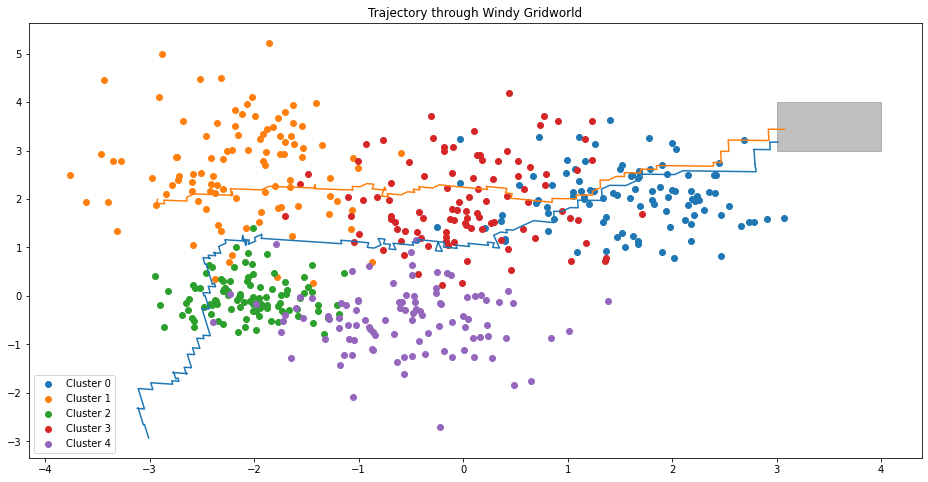

In [59]:
fig, ax2 = plt.subplots(figsize=(16,8))

env.policy_model = pi_b #set policy of agent in the environment

for y in np.linspace(-3,2,2):
    print(y)
    history = env.play(True, [], [], [], [], [], s = np.array([-3, y]))
    print(len(history))
    plt.plot(history[:, 0], history[:, 1])

rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
ax2.add_patch(rect)

for i in range(num_concepts):
    start = i*100
    end = (i+1)*100
    plt.scatter(clusters[start:end,0], clusters[start:end,1], label=f"Cluster {i}")

plt.legend()
plt.title("Trajectory through Windy Gridworld")
plt.show()

### $\pi_b(a|c=f(\hat{s}))$
For use in concept IS. Can also just use default policy used to generate data, inherent to the dataset $\mathcal{D}$, but would like to try both.

In [6]:
# from models.policy import PolicyModel

# X_train, X_test, y_train, y_test = generate_default_dataset(window_size=10)
# #conver to concepts here
# concept_model = keras.models.load_model("saved_models/c|s")
# Xc_train = concept_model.predict(X_train)
# Xc_test = concept_model.predict(X_test)
# pi_b_c = PolicyModel(input_size=Xc_train[0].shape, num_actions=4).build()
# history = pi_b_c.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b_c.save("saved_models/pi_b_c")
pi_b_c = keras.models.load_model("saved_models/pi_b_c") 

In [330]:
input = [0, 1, 0, 0, 0]
input2 = concept_model.predict(np.array([-3,2]).reshape(1,2))[0]
print(input)
print(input2)
print("concept: ", np.argmax(input2))
print(pi_b_c.predict(np.array(input).reshape(1,5))) #action probability distribution for a given concept
print(pi_b_c.predict(np.array(input2).reshape(1,5)))
# np.mean(pi_b_c.predict(Xc_test), axis=0)

[0, 1, 0, 0, 0]
[0.0000000e+00 1.0000000e+00 2.6982219e-09 2.9237873e-15 2.8708091e-34]
concept:  1
[[0.23021428 0.22132175 0.4741072  0.07435676]]
[[0.23021428 0.22132175 0.4741072  0.07435676]]


In [7]:
concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", knn, means, pi_b_c, None, concept_model)

/Users/jackteversham/Documents/Imperial/Thesis/concepts-ope/gridworld/environment.py:141: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions.append(np.array(action_history))


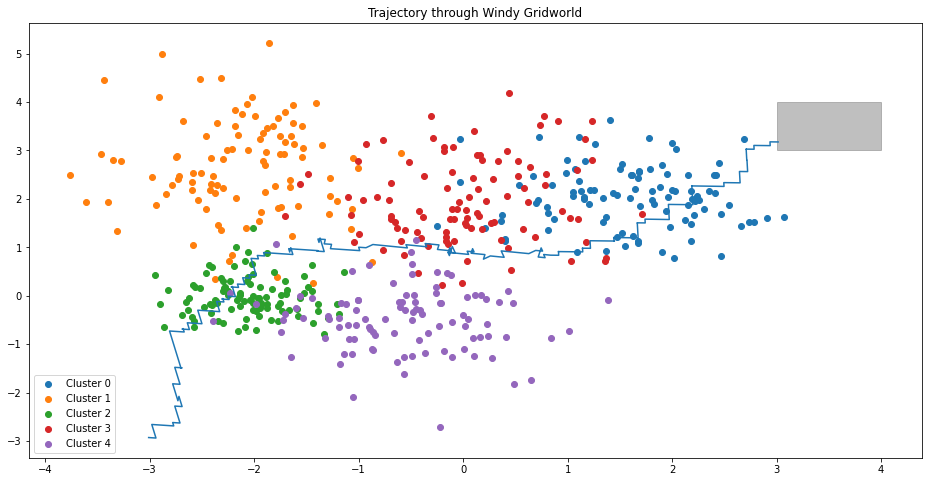

In [61]:
history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Evaluation Policies $\pi_e(a|c=f(\cdot))$ and $\pi_e(a|s)$

These can be created in any way but should try achieve the same goal in the environment as the behavioural policy, and should be created with varying degrees of similarity to the behavioural policy.

### $\pi_e(a|s)$

In [6]:
def eval_policy_a_s(s, A, trajectory=None, concept_model=None, window_states=None):
    s = s.reshape((1,2))
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.13, 0.35, 0.17] #a new distribution of actions, different from behavioural policy

    return A[np.random.choice(indices, 1, p=p)[0]], p

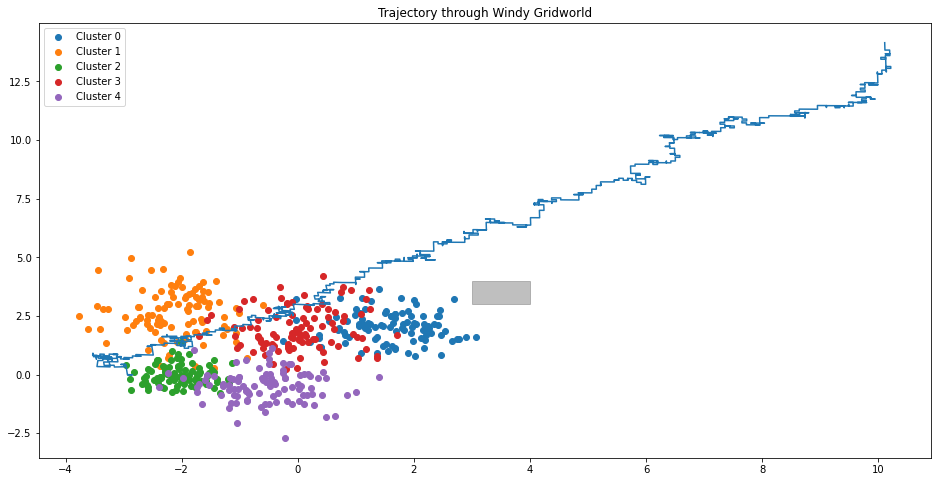

In [7]:
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, eval_policy_a_s)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s))$
Note here that the state is at one time step and not average over a window of $W_s$ previous states.

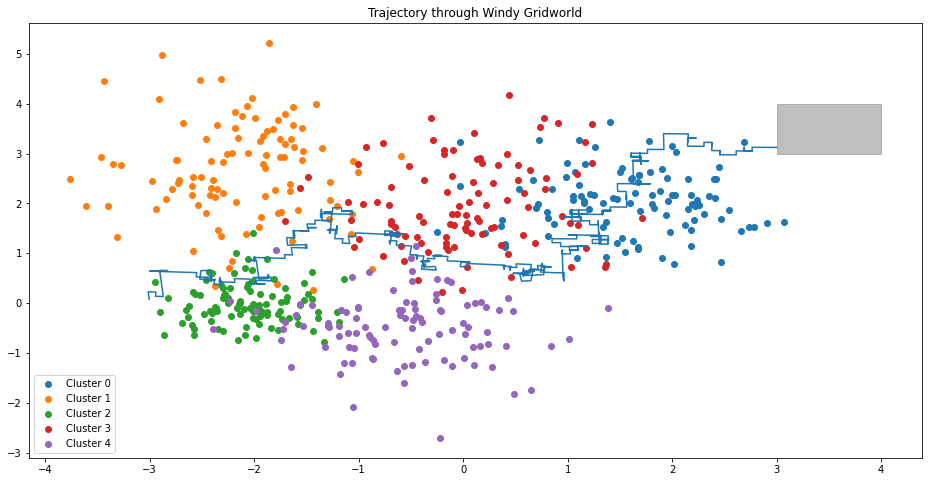

In [8]:
def policy(s, A, trajectory, concept_model, window_states=None):
    s = s.reshape((1,2))
    c = np.argmax(concept_model.predict(s)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p

concept_model = keras.models.load_model("saved_models/c|s") #How can I incorporate future values here? Not possible I dont think. rethink the concept learning using previous values
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,0]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(\hat{s}))$
Note here that the state $\hat{s}$ is averaged over a window of $W_s$ previous states.

/Users/jackteversham/Documents/Imperial/Thesis/concepts-ope/gridworld/environment.py:109: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions.append(np.array(action_history))


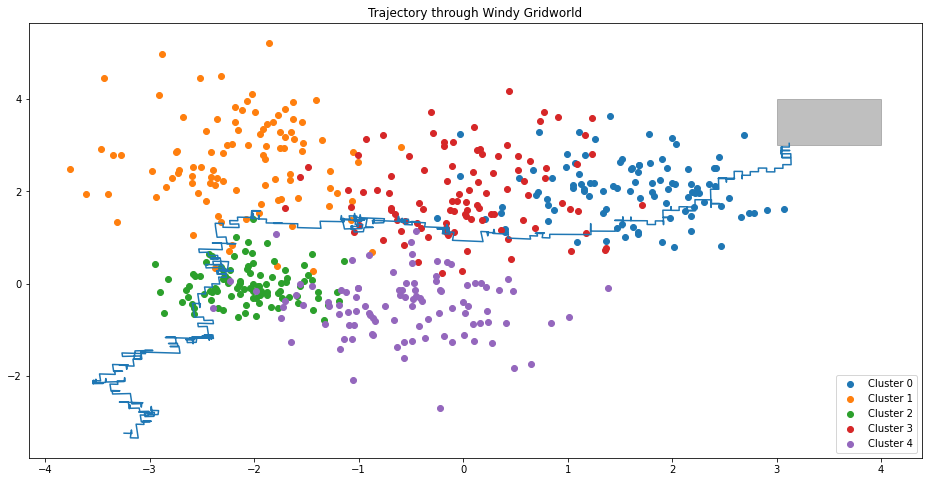

In [10]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    if len(trajectory)==0:
        return s
    s_hat = window_states(trajectory, W_s=10)
    s_hat = s_hat.reshape((1,2))

    c = np.argmax(concept_model.predict(s_hat)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s") 
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

### $\pi_e(a|c=f(s, s'))$
Note here that the state $s'$ is the previous state.

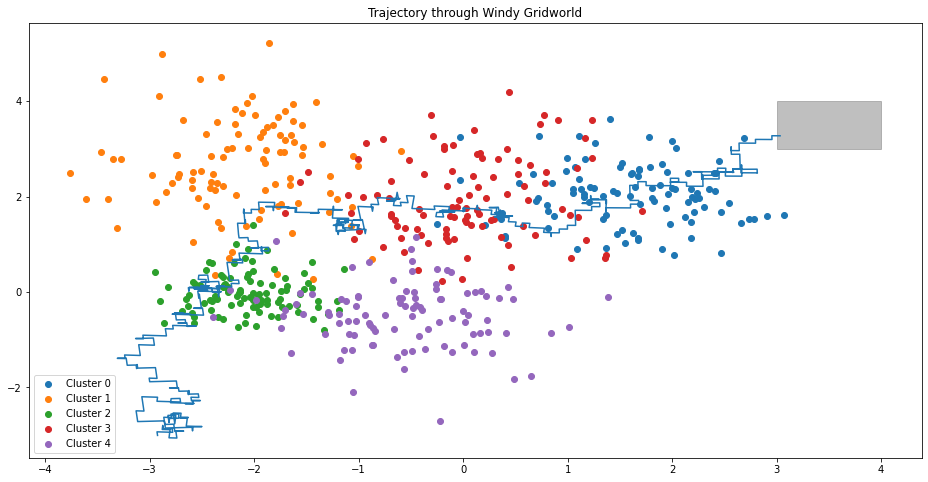

In [11]:
def policy(s, A, trajectory, concept_model, window_states):
    '''Arguments:
    s: current state
    A: action space
    trajectory: the trajectory history up until the current state
    concept_model: the model used to predict the current concept
    window_states: function to average previous states in window of length W_s
    '''
    s_input = np.concatenate([s,s])
    if len(trajectory) > 1:
        s_prime = trajectory[len(trajectory)-1]
        s_input = np.concatenate([s,s_prime])

    s_input = s_input.reshape((1,4))    

    c = np.argmax(concept_model.predict(s_input)) #predict the concept from the current state
    indices = [0, 1, 2, 3] # up, down, right, left
    p=[0.35, 0.15, 0.35, 0.15] #default distribution of actions
    if c== 1:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==2:
        p=[0.4, 0.1, 0.3, 0.2]
    elif c==3:
        p=[0.25, 0.25, 0.4, 0.1]
    elif c==4:
        p=[0.4, 0.1, 0.3, 0.2] #intuitive policy based on concept which is interpretable

    return A[np.random.choice(indices, 1, p=p)[0]], p


def window_states(trajectory, W_s):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    i = len(trajectory)
    window = trajectory[i - min(W_s, i):i]
    s_hat = np.sum(window, axis=0)/len(window)
    return s_hat

concept_model = keras.models.load_model("saved_models/c|s-s_dash")
evaluation_env = WindyGridworld(len(means), "simple", None, means, None, policy, concept_model, window_states)

history = evaluation_env.play(True, [], [], [], [], [], s = np.array([-3,-3]))
evaluation_env.plot_trajectory(history,means,clusters)

## Importance Sampling
We need to compute the value and variance of:
* $V_{IS}$
* $V_{PDIS}$
* $V_{IS}^{concept}$
* $V_{PDIS}^{concept}$

Intuitively, a conceptual region covers more area in the state space and hence there should be more overlap between the behavioural and evaluation policies, and therefore less variance. Note that certain concepts may result in less variance while others may not. We will then need to optimise over the concepts to find the set which reduce the variance the most.

The below formulation is of per-decision importance sampling (PDIS). We need to construct the formulation of vanilla IS too. 

$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|s_t)}{\pi_b(a_t|s_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

In [9]:
class Estimator():

    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]
    A = np.array([up, down, right, left]) #action space

    # These global arrays are updated set per iteration
    behaviour_distributions = []
    evaluation_distributions = []
    behaviour_concepts = []
    action_indicies = []

    def __init__(self, dataset_size, behaviour_trajectories, actions, pi_b_model, pi_e_model, custom_pi_b, custom_pi_e, concept_model, *args, **kwargs):
        self.trajectories = behaviour_trajectories
        self.actions = actions
        self.pi_b_model = pi_b_model
        self.pi_e_model = pi_e_model
        self.custom_pi_b = custom_pi_b
        self.custom_pi_e = custom_pi_e
        self.concept_model = concept_model
        self.dataset_size = dataset_size
        self.args = args
        self.kwargs = kwargs
        self._pre_process()

    def IS():
        pass

    def PDIS(self):   

        value_estimate = 0
        total_likelihood_ratios=0
        non_unit_likelihood_ratios=0

        for t in (range(self.dataset_size)):
            tau = self.trajectories[t]
            behaviour_dist = self.behaviour_distributions[t]
            evaluation_dist = self.evaluation_distributions[t]
            action_idxs = self.action_indicies[t]

            product, count =  self.rho(action_idxs, behaviour_dist, evaluation_dist)
            sum = self.g(tau)
            value_estimate += sum  * product
            non_unit_likelihood_ratios+= count
            total_likelihood_ratios += len(tau)

        return value_estimate/self.dataset_size, (non_unit_likelihood_ratios/total_likelihood_ratios)*100

    def rho(self, actions_idx, behaviour_dist, evaluation_dist):
        product = 1
        count = 0
        
        # self.actions_to_action_indexes(actions)

        # if self.concept_model is not None:
        #     self.__predict_concepts_from_states(tau)
        #     self._predict_actions_from_concepts(self.behaviour_concepts)
        # else:
        #     self._predict_actions_from_states(tau)

        r,_ = behaviour_dist.shape
        behaviour_probabilities = behaviour_dist[np.arange(r), actions_idx]

        for j in range(len(evaluation_dist)):
            epsilon = 0.1
            dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
            if dist_index == 1:
                evaluation_dist[j] = [0.4, 0.1, 0.4, 0.1]

        r,_ = evaluation_dist.shape
        evaluation_probabilities = evaluation_dist[np.arange(r), actions_idx]

        ratios = np.array(evaluation_probabilities/behaviour_probabilities)
        product = np.prod(ratios)
        count = len(np.where((ratios-1.0)>0.01)[0])
        
        return product, count

    def g(self, tau, gamma=1):
        T = len(tau)
        r_t = -1
        return T*r_t
    
    def pi_b_action_probability(self, t, state):
        action_index = self.action_indicies[t]
        if self.pi_b_model is not None:
            distribution = self.behaviour_distributions[t]
            return distribution[action_index]
        
        _, distribution = self.custom_pi_b(state, self.A)
        return distribution[action_index]
        

    def pi_e_action_probability(self, t, state):
        action_index = self.action_indicies[t]
        if self.pi_e_model is not None:
            distribution = self.behaviour_distributions[t]
            epsilon = 0.1
            dist_index = np.random.choice([0,1],1,p=[1-epsilon,epsilon])[0]
            distributions = [distribution, [0.4, 0.1, 0.4, 0.1]] #sample from model distribution with probability 1-eps and randomly with probability epsilon
            p = distributions[dist_index]
            return p[action_index]
        
        _, distribution = self.custom_pi_e(state, self.A)
        return distribution[action_index]
    
    def _pre_process(self):
        print("Pre-processing data....")
        for idx in range(len(self.trajectories)):
            actions = self.actions[idx]
            trajectory = self.trajectories[idx]
            self.action_indicies.append(self.actions_to_action_indexes(actions))

            if self.concept_model is not None:
                concepts = self._predict_concepts_from_states(trajectory)
                self.behaviour_distributions.append(self._predict_actions_from_concepts(concepts))
            else:
                self.behaviour_distributions.append(self._predict_actions_from_states(trajectory))
        
        self.evaluation_distributions = np.copy(self.behaviour_distributions)
        print("Finished. Starting evaluation....")


    def actions_to_action_indexes(self, actions):
        '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
        return np.array([np.where(np.all((self.A == a), axis=1))[0][0] for a in actions])

    def _predict_concepts_from_states(self, trajectory):
        return np.array(self.concept_model.predict(trajectory))

    def _predict_actions_from_states(self, trajectory):
        return np.array(self.pi_b_model.predict(trajectory)) 
        # self.evaluation_distributions = np.copy(self.behaviour_distributions)
   
    def _predict_actions_from_concepts(self, concepts):
        return np.array(self.pi_b_model.predict(concepts))
        # self.evaluation_distributions = np.copy(self.behaviour_distributions)


        

In [12]:
D = 25
print(D)
estimator = Estimator(dataset_size=D, behaviour_trajectories=trajectories, actions=actions, pi_b_model=pi_b, pi_e_model=pi_b, custom_pi_b=None, custom_pi_e=None, concept_model=None)
concept_estimator = Estimator(dataset_size=D, behaviour_trajectories=trajectories, actions=actions, pi_b_model=pi_b_c, pi_e_model=pi_b_c, custom_pi_b=None, custom_pi_e=None, concept_model=concept_model)

values1, values2, ess_values1, ess_values2 = [], [], [], []

for i in tqdm(range(20)):
    estimate, ESS = estimator.PDIS()
    estimate_concepts, concept_ESS = concept_estimator.PDIS()
    # print(ESS, concept_ESS)
    values1.append(estimate)
    values2.append(estimate_concepts)
    ess_values1.append(ESS)
    ess_values2.append(concept_ESS)
print("Vanilla PDIS estimates: ", values1)
print("Concepts PDIS estimates: " ,values2)
print("Mean ESS: ",np.array(ess_values1).mean())
print("Mean Concept ESS: ",np.array(ess_values2).mean())
#Note counter value is number of non unit likelihood ratios in an estimation trial with dataset size 25 and mean trajectory length roughly 100-250

25
Pre-processing data....


/opt/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:935: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, order=order, subok=subok, copy=True)


Finished. Starting evaluation....
Pre-processing data....
Finished. Starting evaluation....



Vanilla PDIS estimates:  [-357.5793343424797, -328.7540147018433, -358.9437801027298, -353.3491303873062, -334.7397224998474, -342.5575126981735, -351.21108376026154, -327.98432403564453, -336.3583419942856, -342.09151186466215, -347.22222855806353, -347.2800178146362, -336.04035785675046, -344.7194738721848, -339.12, -339.12, -336.7739514446259, -339.12, -335.940612449646, -342.8510295295715]
Concepts PDIS estimates:  [-340.7375607967377, -336.36544191360474, -333.54953993082046, -319.21942869186404, -335.6342136573792, -335.78918087244034, -336.4218124246597, -347.60698973178864, -350.41681619644163, -345.5540660190582, -342.9010772204399, -330.66318422555923, -337.19037272453306, -339.12, -339.12, -341.39490010261534, -339.12, -339.12, -339.12, -339.12]
Mean ESS:  0.021821184241566406
Mean Concept ESS:  0.012974758197688133


In [357]:
for i, val in enumerate(values2):
    if val== -5021.978055494754:
        print("True")
        values2[i] = -1000

True


In [13]:
df = pd.DataFrame({"vanilla":np.array(values1),"concepts":np.array(values2)})
print(df.describe())


          vanilla    concepts
count   20.000000   20.000000
mean  -342.087821 -338.408229
std      8.546322    6.462104
min   -358.943780 -350.416816
25%   -347.236676 -340.901896
50%   -340.605756 -339.120000
75%   -336.278846 -336.221377
max   -327.984324 -319.219429


Some questions
1. Evaluate over full dataset? or sample different sized datasets from D?
2. The value of some estimates seems pretty low, is this normal?
3. Trajecotries are pretty long, is this an issue?
4. Choosing the evaluation policy - increase epslion for example? 

Considerations:

- changing policy to epsilon greedy on taking argmax of distribution. Or do we just sample action according to distribution (can't just be this)?
- Omitting likelihood ratios is equivalent to setting them to 1
- Over different simulations, the distribution over states should vary more than the distrbiution over concepts, hence higher variance